In [1]:


import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/pix2pix-dataset/facades/facades/train/170.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/234.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/287.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/87.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/167.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/138.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/257.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/163.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/148.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/238.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/38.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/251.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/184.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/264.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/278.jpg
/kaggle/input/pix2pix-dataset/facades/facades/train/99.jpg
/kaggle/input/pix2pix-dataset/facades/facad

In [2]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

Using TensorFlow backend.


In [3]:
def load_images(path, size=(256,512)):
    src_list, tar_list = list(), list()
    for filename in listdir(path):
        pixels = load_img(path + filename, target_size=size)
        pixels = img_to_array(pixels)
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
        return [asarray(src_list), asarray(tar_list)]
    

In [4]:
path = '/kaggle/input/pix2pix-dataset/maps/maps/train/'
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1, 256, 256, 3) (1, 256, 256, 3)
Saved dataset:  maps_256.npz


In [5]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset

Loaded:  (1, 256, 256, 3) (1, 256, 256, 3)


IndexError: index 1 is out of bounds for axis 0 with size 1

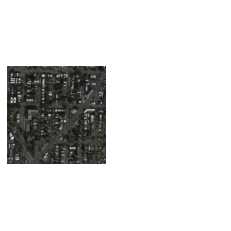

In [6]:
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(1, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(src_images[i].astype('uint8'))
for i in range(n_samples):
    pyplot.subplot(1, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [7]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4,4), strides=(2,2), 
               padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [8]:
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    in_src_image = Input(shape=image_shape)
    in_target_image = Input(shape=image_shape)
    merged = Concatenate()([in_src_image, in_target_image])
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    model = Model([in_src_image, in_target_image], patch_out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [9]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)r
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

In [10]:
def define_generator(image_shape=(256,256,3)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    model = Model(in_image, out_image)
    return model

In [11]:
def define_gan(g_model, d_model, image_shape):
    d_model.trainable = False
    in_src = Input(shape=image_shape)
    gen_out = g_model(in_src)
    dis_out = d_model([in_src, gen_out])
    model = Model(in_src, [dis_out, gen_out])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [12]:
def load_real_samples(filename):
    data = load(filename)
    X1, X2 = data['arr_0'], data['arr_1']
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]
    

In [13]:
def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    ix = randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [14]:
def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [15]:
def summarize_performance(step, g_model, dataset, n_samples=3):
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [16]:
def train(d_model, g_model, gan_model, dataset, n_epochs=200, n_batch=1):
    n_patch = d_model.output_shape[1]
    trainA, trainB = dataset
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [17]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint

In [18]:
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)
train(d_model, g_model, gan_model, dataset)

Loaded (1, 256, 256, 3) (1, 256, 256, 3)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d1[0.350] d2[0.747] g[86.712]
>2, d1[0.283] d2[0.479] g[84.293]


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>3, d1[0.187] d2[0.308] g[81.973]
>4, d1[0.180] d2[0.224] g[79.531]
>5, d1[0.148] d2[0.203] g[77.071]
>6, d1[0.138] d2[0.158] g[74.589]
>7, d1[0.135] d2[0.113] g[71.952]
>8, d1[0.097] d2[0.106] g[69.433]
>9, d1[0.056] d2[0.078] g[67.020]
>10, d1[0.039] d2[0.055] g[64.555]
>Saved: plot_000010.png and model_000010.h5
>11, d1[0.031] d2[0.045] g[62.067]
>12, d1[0.027] d2[0.041] g[59.601]
>13, d1[0.025] d2[0.037] g[57.146]
>14, d1[0.023] d2[0.033] g[54.725]
>15, d1[0.022] d2[0.029] g[52.325]
>16, d1[0.020] d2[0.027] g[49.945]
>17, d1[0.019] d2[0.024] g[47.609]
>18, d1[0.018] d2[0.023] g[45.326]
>19, d1[0.017] d2[0.022] g[43.063]
>20, d1[0.016] d2[0.021] g[40.876]
>Saved: plot_000020.png and model_000020.h5
>21, d1[0.016] d2[0.020] g[38.717]
>22, d1[0.016] d2[0.020] g[36.646]
>23, d1[0.016] d2[0.021] g[34.646]
>24, d1[0.017] d2[0.020] g[32.682]
>25, d1[0.017] d2[0.021] g[30.876]
>26, d1[0.023] d2[0.052] g[29.697]
>27, d1[1.127] d2[2.044] g[22.963]
>28, d1[0.044] d2[0.741] g[23.077]
>29, d1[0

Loaded (1, 256, 256, 3) (1, 256, 256, 3)


/opt/conda/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


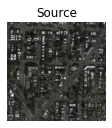

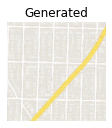

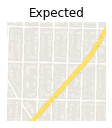

In [20]:
def load_real_samples(filename):
    data = load(filename)
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    for i in range(len(images)):
        pyplot.subplot(1, 3, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(images[i])
        pyplot.title(titles[i])
        pyplot.show()
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)
model = load_model('model_000100.h5')
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = model.predict(src_image)
plot_images(src_image, gen_image, tar_image)        
        
